In [38]:
from keras.metrics import mean_squared_error
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from typing import Tuple
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MaxPooling1D, Conv1D, UpSampling1D, Reshape, TimeDistributed, Bidirectional

In [39]:
# Constants
INPUT_FEATURES = 26                # Number of input features (e.g., temperature, humidity, etc.)
SEQUENCE_LEN = 21 * 4              # 21 days of 6-hours data
OUTPUT_LEN = 5 * 4                 # 5 days of 6-hours data
OUTPUT_FEATURES = 3 * OUTPUT_LEN   # Predicting 3 features for each day

In [40]:
def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LEN - OUTPUT_LEN):
        X.append(data[i: i + SEQUENCE_LEN])
        y.append(data[i + SEQUENCE_LEN: i + SEQUENCE_LEN + OUTPUT_LEN, :3].flatten()) # Taking the first 3 features for the next 24 hours
    return np.array(X), np.array(y)


def invert_scale(data, scaler):
    copy_data = data.copy()
    for i in range(3):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_data[:, i::3] = data[:, i::3] * std + mean
    return copy_data


def MSE(y_true, y_pred):
    T_mse = np.mean((y_true[:, 0::3] - y_pred[:, 0::3])**2, axis=0).reshape(1, -1)
    P_mse = np.mean((y_true[:, 1::3] - y_pred[:, 1::3])**2, axis=0).reshape(1, -1)
    R_mse = np.mean((y_true[:, 2::3] - y_pred[:, 2::3])**2, axis=0).reshape(1, -1)
    
    MSE_by_hour = np.append(np.append(T_mse, P_mse, axis=0), R_mse, axis=0)
    
    return MSE_by_hour, np.mean(MSE_by_hour, axis=1), np.mean(MSE_by_hour)


def plot_one_prediction(idx: int, X_true, y_true, y_pred, scaler, figsize: Tuple[int] = (15, 10)):
    x = range(SEQUENCE_LEN + OUTPUT_LEN)
    x1, x2 = x[1:1 + SEQUENCE_LEN], x[SEQUENCE_LEN:]
    labels = ['Temperature [C]', 'Pressure [hPa]', 'Rainfall [mm]']

    fig, axs = plt.subplots(3, figsize=figsize)
    fig.suptitle('Weather Forecast: Actual vs Predicted')
    for i in range(3):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        axs[i].plot(x1, X_true[idx + 1, :, i] * std + mean, label='Given data', color='green')
        axs[i].plot(x2, y_true[:, i::3][idx] * std + mean, label='Actual', color='blue')
        axs[i].plot(x2, y_pred[:, i::3][idx] * std + mean, label='Predicted', color='red')
        axs[i].set_ylabel(labels[i])
        axs[i].grid()
        axs[i].legend()
    axs[2].set_xlabel('Time (Hours)')
    plt.show()

In [41]:
data = pd.read_csv('../data/preprocessed_data/complete_krk_2017-22.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')
data_6h = data[data.index.hour.isin([0, 6, 12, 18])]

In [42]:
# Assuming 'data' is your dataset with shape (total_hours, 26_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_6h)
data_normalized

array([[-1.84111251,  0.96474493, -0.15044506, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.8746059 ,  0.60170017, -0.15044506, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.57952796,  0.22613662, -0.15044506, ..., -0.15217187,
        -0.12556201, -0.28491282],
       ...,
       [-1.11542228,  0.1635427 , -0.15044506, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [ 0.25780691,  0.25117419, -0.15044506, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.07712704,  0.37636204, -0.15044506, ..., -0.15217187,
        -0.12556201, -0.28491282]])

In [43]:
# Create sequences
X, y = create_sequences(data_normalized)

In [44]:
train_size = 4 * (365 * 3 + 366)
val_size = 4 * 365

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [45]:
input_layer = Input(shape=(84, 26))  # 21 days * 4 hours (0,6,12,18), 26 parameters

reshape = Reshape((26, 84)) (input_layer)
# Downsampling
conv1 = Conv1D(filters=24, kernel_size=7, activation='relu', strides=1, padding="causal") (reshape)
lstm1 = Bidirectional(LSTM(84, return_sequences=True))(conv1)

lstm2 = Bidirectional(LSTM(42, return_sequences=False))(lstm1)

# Output layer
output_layer = Dense(60, activation='linear') (lstm2)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust optimizer and loss as needed
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 84, 26)]          0         
                                                                 
 reshape_1 (Reshape)         (None, 26, 84)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 24)            14136     
                                                                 
 bidirectional_2 (Bidirecti  (None, 26, 168)           73248     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 84)                70896     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 60)                5100

In [48]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
183/183 [==============================] - 19s 59ms/step - loss: 0.7329 - val_loss: 0.9786
Epoch 2/20
183/183 [==============================] - 8s 46ms/step - loss: 0.6134 - val_loss: 0.9841
Epoch 3/20
183/183 [==============================] - 9s 48ms/step - loss: 0.5598 - val_loss: 1.0000
Epoch 4/20
183/183 [==============================] - 9s 48ms/step - loss: 0.5070 - val_loss: 1.0209
Epoch 5/20
183/183 [==============================] - 9s 47ms/step - loss: 0.4654 - val_loss: 1.0270
Epoch 6/20
183/183 [==============================] - 9s 47ms/step - loss: 0.4363 - val_loss: 1.0335
Epoch 7/20
183/183 [==============================] - 9s 47ms/step - loss: 0.4090 - val_loss: 1.0384
Epoch 8/20
183/183 [==============================] - 9s 51ms/step - loss: 0.3888 - val_loss: 1.0444
Epoch 9/20
183/183 [==============================] - 9s 49ms/step - loss: 0.3705 - val_loss: 1.0426
Epoch 10/20
183/183 [==============================] - 9s 48ms/step - loss: 0.3541 - val_l

In [49]:

model.save('CNN&LSTM_6h_29-12-2023_baseline')

INFO:tensorflow:Assets written to: CNN&LSTM_6h_29-12-2023_baseline\assets


INFO:tensorflow:Assets written to: CNN&LSTM_6h_29-12-2023_baseline\assets


In [18]:
from keras.models import load_model

model = load_model('CNN&LSTM_6h_29-12-2023_baseline')
history = model.history

In [11]:
loss = history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

TypeError: 'History' object is not subscriptable

In [50]:
# Make predictions
y_pred = model.predict(X_test)

43/43 [==============================] - 2s 25ms/step


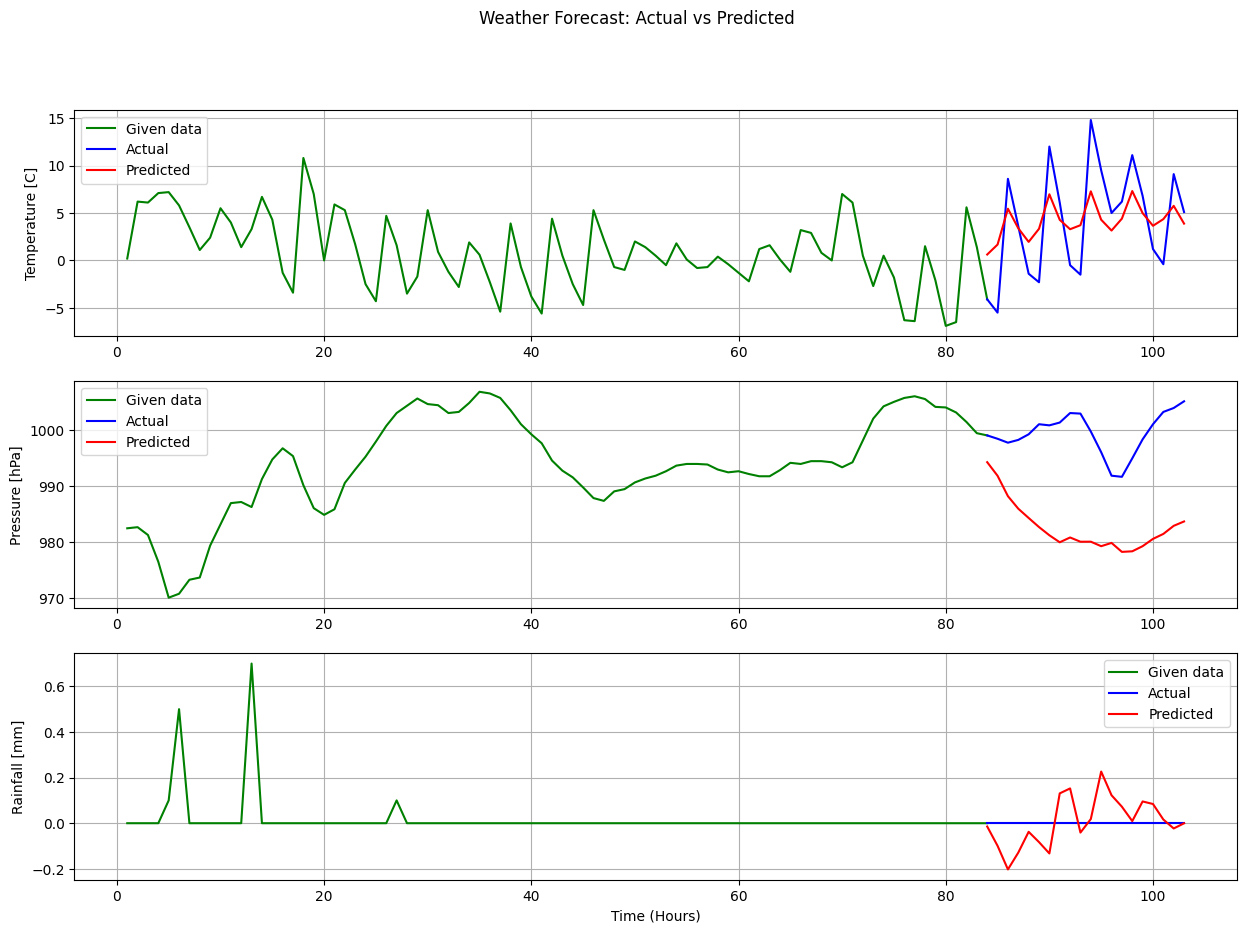

In [58]:
plot_one_prediction(200, X_test, y_test, y_pred, scaler)

In [52]:
MSE(invert_scale(y_test, scaler), invert_scale(y_pred, scaler))[0]

array([[12.63874728, 15.34865878, 16.41744931, 17.04727402, 17.38686032,
        20.77893136, 21.69922026, 21.52982033, 22.04996291, 23.78229801,
        24.39942122, 23.63227307, 24.37355728, 25.81293574, 25.6964848 ,
        23.79451454, 24.35879578, 25.57300207, 25.51762952, 23.88764313],
       [12.2320551 , 18.74344389, 28.4375723 , 38.02048394, 47.93883079,
        57.90328624, 65.302211  , 71.95502012, 78.21102156, 83.49648833,
        88.58805533, 91.23737135, 93.06009411, 92.71130608, 91.08216679,
        89.78591854, 92.01458155, 93.09954045, 95.44685973, 95.19442374],
       [ 0.16179313,  0.16365372,  0.16526921,  0.16447144,  0.16455068,
         0.16613089,  0.16786428,  0.15884075,  0.14902706,  0.15097937,
         0.15631921,  0.16807415,  0.1550355 ,  0.16063405,  0.16504701,
         0.15908752,  0.15241016,  0.15162596,  0.15431213,  0.15800665]])

In [53]:
MSE(invert_scale(y_test, scaler), invert_scale(y_pred, scaler))[1]

array([21.78627399, 71.22303655,  0.15965664])